# Projet Data Mining

Max length = 2753
Max time = 2751 days 23:00:00


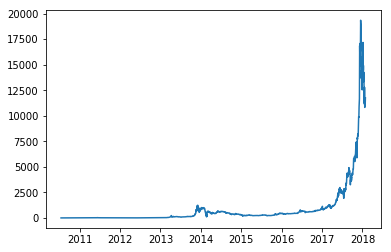

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np 
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

def daily_price_historical(symbol, comparison_symbol, histoday=True, limit=1, aggregate=1, allData='true'):
    # api url
    if histoday:
        url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}&allData={}' \
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)
    else:
        url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}&allData={}' \
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)

    # fetch data
    page = requests.get(url)
    data = page.json()['Data']

    # Convert Json to Table
    df = pd.DataFrame(data)

    # add a column with timestamp
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]

    return df


df = daily_price_historical('BTC', 'USD', True)
print('Max length = {}'.format(len(df)))
print('Max time = {}'.format((df.timestamp.max() - df.timestamp.min())))

plt.plot(df.timestamp, df.close)
plt.show()
df.head(5)
df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d')

In [2]:
df2 = df.set_index('timestamp')
df2
ecart = df2['close']-df2['open']

In [3]:
pa = pd.read_csv('crypto_learning/results.csv', usecols=["Date","Value"])
pa['Date'] = [pd.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in pa.Date]
pa = pa.set_index('Date')

18


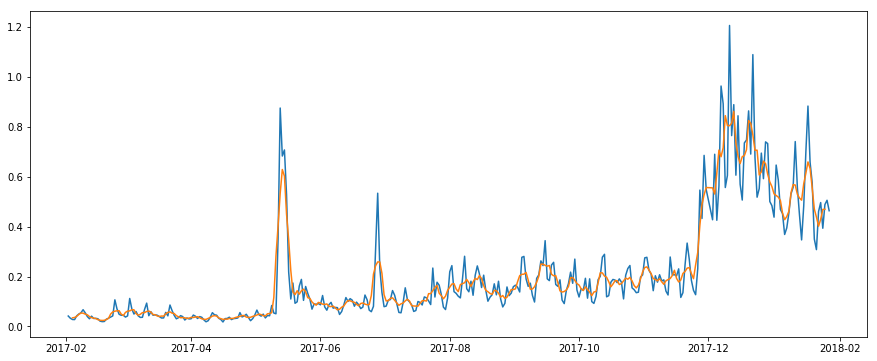

In [4]:
rcParams['figure.figsize'] = 15, 6
pa['mean'] = pa.rolling(window=5, center=True).mean()
ts = pa['mean']

print(np.count_nonzero(abs(ts-pa['Value'])>0.15))

plt.plot(pa)

### Création colonne buzz

In [5]:
pa['buzz']='c'
pa['buzz'][(pa['Value']-ts)>0.15]='u'
pa['buzz'][(pa['Value']-ts)<-0.15]='d'

C:\Users\Hecto\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Hecto\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
pa[pa['buzz']!='c']

,open,close,buzz
Date,,,
2017-05-11,1752.31,1819.29,d
2017-05-13,1686.39,1763.74,u
2017-06-28,2583.75,2577.74,u
2017-11-29,9906.04,9837.86,u
2017-12-04,11244.20,11623.91,u
2017-12-05,11624.37,11667.13,d
2017-12-07,13750.09,16850.31,u
2017-12-08,16867.98,16047.61,u
2017-12-09,16048.18,14843.42,d


### Concaténation avec la première table

In [7]:
pa = pa.join(df2)

In [8]:
pa = pa[['open','close','buzz']]

### Création de la variable d'ecart

In [9]:
df = np.array(df)
ecart = df[:,0]-df[:,3]

epsilon1 = 0.005
epsilon2 = 2

ecart[(ecart<df[:,3]*epsilon1) & (ecart>-df[:,3]*epsilon1)] = 0
ecart[(ecart>df[:,3]*epsilon1) & (ecart<df[:,3]*epsilon2)] = 1
ecart[ecart>df[:,3]*epsilon2] = 2
ecart[ecart<-df[:,3]*epsilon2] = -2                                 
ecart[(ecart<-df[:,3]*epsilon1) & (ecart>-df[:,3]*epsilon2)] = -1

print(sum(ecart==-2))
print(sum(ecart==-1))
print(sum(ecart==0))
print(sum(ecart==1))
print(sum(ecart==2))

0
964
571
1129
89


### Fonction de création des séquences

In [10]:
def sequences(taille, tab) :
    seq = [tab[i:(i+taille)] for i in range(len(tab[:-(taille-1)]))]
    return seq

### Recherche des séquences qui se répètent de taille max

In [11]:
from collections import Counter
seqtest = sequences(3,ecart)
occmax = 1
tailleseq = 31
while occmax < 2 :
    seqtest = sequences(tailleseq,ecart)
    c = Counter(map(tuple,seqtest))
    c = pd.DataFrame.from_dict(c,orient='index').reset_index()
    c = c.rename(columns = {"index":"sequences",0:"occurences"} )
    c = c.sort_values(by="occurences",ascending=False)
    c = c.reset_index(drop = True)
    c= np.array(c)
    occmax = max(occmax,c[0,1])
    print(occmax)
    tailleseq -= 1
    
print(tailleseq+1)
print(c)
#c[sum(abs(c))>1]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
17
[[(0, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1) 2]
 [(0, 2, -1, -1, 2, -1, 2, -1, -1, 2, 2, -1, 2, -1, 2, -1, -1) 1]
 [(1, -1, 0, 0, 1, 0, 1, 0, 0, -1, 0, -1, -1, 0, 0, 1, -1) 1]
 ..., 
 [(1, -1, 1, 1, 1, 1, -1, 1, 1, 0, 1, 1, 1, 1, 0, -1, 1) 1]
 [(-1, 1, 1, 1, 1, -1, 1, 1, 0, 1, 1, 1, 1, 0, -1, 1, -1) 1]
 [(1, 1, -1, 0, -1, -1, 0, 1, 1, -1, -1, 0, 1, -1, -1, 1, 1) 1]]
